###Github Issue Labelling Bot

####Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path_to_file = 'drive/My Drive/Colab Notebooks/processed_data.csv'
df = pd.read_csv(path_to_file)
df.head()

,issue,label,label_name
0,append new column neccesary bot append new col...,0,bug
1,student currentsemester would show sections st...,0,bug
2,duplicate articles toc causes weird behavior t...,0,bug
3,fix typo collection finder py summary describe...,0,bug
4,zimagi dbshell find psql moreover looks even p...,0,bug


In [ ]:
df.shape

(22075, 4)

####Dataset visualization

In [ ]:
x = ['bug','design', 'documentation','feature', 'help','question']

y = list(df['label'].value_counts())

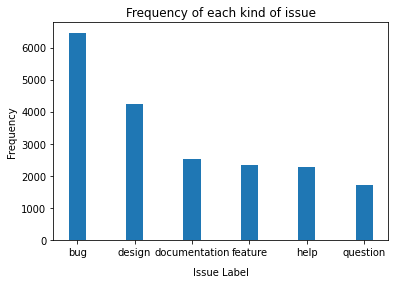

In [ ]:
plt.bar(x, y, width = 0.3)
plt.title("Frequency of each kind of issue")
plt.xlabel("Issue Label", labelpad=10)
plt.ylabel("Frequency")
plt.show()

In [ ]:
vect = CountVectorizer(max_features=1000, max_df=.15)
X = vect.fit_transform(df['issue'])
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(learning_method="batch", max_iter=10, random_state=0)
document_topics = lda.fit_transform(X)

In [ ]:
!pip install mglearn

In [ ]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
import mglearn
mglearn.tools.print_topics(topics=range(6), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
change        js            name          user          java          
tests         node          silly         page          org           
changes       error         class         info          io            
fix           build         type          main          com           
code          modules       value         button        netty         
test          version       data          search        size          
pr            config        import        submitted     base          
added         module        false         components    util          
update        install       true          ui            jar           
fixes         server        error         click         core          


topic 5       
--------      
data          
log           
kafka         
dataset       
debug         
app           
info          
content    

In [ ]:
df['word_count'] = df['issue'].str.count(' ') + 1
df.head()

,issue,label,label_name,word_count
0,append new column neccesary bot append new col...,0,bug,10
1,student currentsemester would show sections st...,0,bug,13
2,duplicate articles toc causes weird behavior t...,0,bug,94
3,fix typo collection finder py summary describe...,0,bug,66
4,zimagi dbshell find psql moreover looks even p...,0,bug,49


In [ ]:
vec = CountVectorizer(stop_words = 'english').fit(df['issue'])
bag_of_words = vec.transform(df['issue'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
common_words = words_freq[:20]
df2 = pd.DataFrame(common_words, columns = ['issue words' , 'count'])

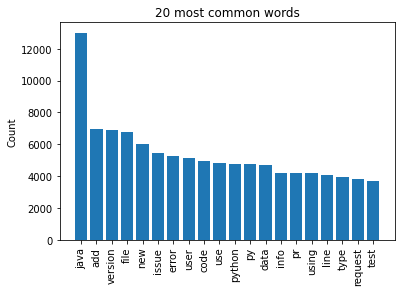

In [ ]:
x , y = zip(*common_words)
plt.bar(x, y)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("20 most common words")
plt.show()

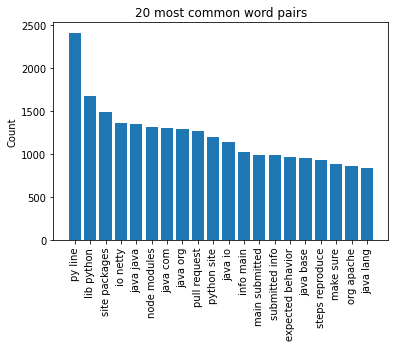

In [ ]:
vec = CountVectorizer(ngram_range=(2, 2)).fit(df['issue'])
bag_of_words = vec.transform(df['issue'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
common_wordpairs = words_freq[:20]
x2, y2 = zip(*common_wordpairs)
plt.bar(x2, y2)
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("20 most common word pairs")
plt.show()

####Splitting into train and test

In [8]:
x = df.drop(labels=['label', 'label_name'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, df['label'], test_size = 0.25, random_state = 53)
x_train.head()

,issue
10072,add tab processing c nwb docs processing modul...
15350,android guidelines fit content new guidelines ...
19483,fix error loading cheat sheet content sorry wr...
3572,actually able lose hitting guard lose
10553,teleport pad updating mods version use telepor...


In [9]:
y_train.head()

10072    3
15350    2
19483    4
3572     3
10553    5
Name: label, dtype: int64

####Word Vectors

In [11]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(x_train['issue'])
count_test = count_vectorizer.transform(x_test['issue'])

In [12]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_train = tfidf_vectorizer.fit_transform(x_train['issue']) 
tfidf_test = tfidf_vectorizer.transform(x_test['issue'])

####Random Forest

In [13]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=53, n_jobs=-1, max_depth=25)
rf_clf.fit(count_train, y_train)
pred = rf_clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("Accuracy for Random Forest with BoW:   %0.3f" % score)

Accuracy for Random Forest with BoW:   0.508


In [14]:
rf_clf = RandomForestClassifier(n_estimators=150, random_state=53, n_jobs=-1, max_depth=30)
rf_clf.fit(tfidf_train, y_train)
pred = rf_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("Accuracy for Random Forest with TF-IDF:   %0.3f" % score)

Accuracy for Random Forest with TF-IDF:   0.520


####Decision Tree

In [15]:
dt_clf = DecisionTreeClassifier(max_depth=25)
dt_clf.fit(count_train, y_train)
pred = dt_clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("Accuracy for Decision Tree with BoW:   %0.3f" % score)

Accuracy for Decision Tree with BoW:   0.591


In [16]:
dt_clf = DecisionTreeClassifier(splitter='random', max_depth=30)
dt_clf.fit(tfidf_train, y_train)
pred = dt_clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("Accuracy for Decision Tree with TF-IDF:   %0.3f" % score)

Accuracy for Decision Tree with TF-IDF:   0.575


####Using RCNN

In [ ]:
path_to_file = 'drive/My Drive/Colab Notebooks/glove.6B.50d.txt'

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(path_to_file, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

def Build_Model_RCNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50):

    kernel_size = 2
    filters = 256
    pool_size = 2
    gru_node = 256

    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)

            embedding_matrix[i] = embedding_vector



    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, return_sequences=True, recurrent_dropout=0.2))
    model.add(LSTM(gru_node, recurrent_dropout=0.2))
    model.add(Dense(1024,activation='relu'))
    model.add(Dense(nclasses))
    model.add(Activation('softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

df = pd.read_csv("drive/My Drive/Colab Notebooks/processed_data.csv")
x_df = df.drop(labels=["label_name", "label"], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_df, df['label'], test_size = 0.2, random_state = 53)

X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(x_train['issue'], x_test['issue'])

model_RCNN = Build_Model_RCNN_Text(word_index,embeddings_index, 20)
model_RCNN.summary()
model_RCNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=15,
                              batch_size=128,
                              verbose=2)
predicted = model_RCNN.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)
print(metrics.classification_report(y_test, predicted))

Found 53409 unique tokens.
(19525, 500)
Total 400001 word vectors.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           2670500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 499, 256)          25856     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 249, 256)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 248, 256)          131328    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 124, 256)          0         
_____________________________________________________

In [ ]:
model_RCNN.save('drive/My Drive/Colab Notebooks/rcnn')

INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/rcnn/assets
